In [ ]:
# if importing from colab:
# change the reading of data as well
"""
from google.colab import drive
drive.mount("/content/Google_Drive", force_remount=True)
"""

'\nfrom google.colab import drive\ndrive.mount("/content/Google_Drive", force_remount=True)\n'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_error = pd.read_csv("/content/PdM_errors.csv")
df_fail = pd.read_csv("/content/PdM_failures.csv")
df_mach = pd.read_csv("/content/PdM_machines.csv")
df_maint = pd.read_csv("/content/PdM_maint.csv")
df_telem = pd.read_csv("/content/PdM_telemetry.csv")

In [ ]:
print("Errors :\n", df_error, "\n\n***********\n")
print("Failures :\n", df_fail, "\n\n***********\n")
print("Machine detail :\n", df_mach, "\n\n***********\n")
print("Maintenance :\n", df_maint, "\n\n***********\n")
print("Telemetry :\n", df_telem)

Errors :
                  datetime  machineID errorID
0     2015-01-03 07:00:00          1  error1
1     2015-01-03 20:00:00          1  error3
2     2015-01-04 06:00:00          1  error5
3     2015-01-10 15:00:00          1  error4
4     2015-01-22 10:00:00          1  error4
...                   ...        ...     ...
3914  2015-11-21 08:00:00        100  error2
3915  2015-12-04 02:00:00        100  error1
3916  2015-12-08 06:00:00        100  error2
3917  2015-12-08 06:00:00        100  error3
3918  2015-12-22 03:00:00        100  error3

[3919 rows x 3 columns] 

***********

Failures :
                 datetime  machineID failure
0    2015-01-05 06:00:00          1   comp4
1    2015-03-06 06:00:00          1   comp1
2    2015-04-20 06:00:00          1   comp2
3    2015-06-19 06:00:00          1   comp4
4    2015-09-02 06:00:00          1   comp4
..                   ...        ...     ...
756  2015-11-29 06:00:00         99   comp3
757  2015-12-14 06:00:00         99   comp4
75

In [ ]:
df_error.isnull().sum()

datetime     0
machineID    0
errorID      0
dtype: int64

In [ ]:
df_fail.isnull().sum()

datetime     0
machineID    0
failure      0
dtype: int64

In [ ]:
df_mach.isnull().sum()

machineID    0
model        0
age          0
dtype: int64

In [ ]:
df_maint.isnull().sum()

datetime     0
machineID    0
comp         0
dtype: int64

In [ ]:
df_telem.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [ ]:
# convert all datetime

df_error['datetime'] = pd.to_datetime(df_error['datetime'])
df_fail['datetime'] = pd.to_datetime(df_fail['datetime'])
df_maint['datetime'] = pd.to_datetime(df_maint['datetime'])
df_telem['datetime'] = pd.to_datetime(df_telem['datetime'])

In [ ]:
# label encode all machineID and errorID

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_error['errorID'] = le.fit_transform(df_error['errorID'])
df_error['machineID'] = le.fit_transform(df_error['machineID'])
df_mach["machineID"] = le.fit_transform(df_mach["machineID"])
df_telem["machineID"] = le.fit_transform(df_telem["machineID"])

In [ ]:
# seperate component failures into individual columns
df_fail["no_fail"] = df_fail['failure'].isnull()

for i in ["comp1", "comp2", "comp3", "comp4"]:
  df_fail[f"fail_{i}"] = (df_fail['failure'] == i)

In [ ]:
df_fail

,datetime,machineID,failure,no_fail,fail_comp1,fail_comp2,fail_comp3,fail_comp4
0,2015-01-05 06:00:00,1,comp4,False,False,False,False,True
1,2015-03-06 06:00:00,1,comp1,False,True,False,False,False
2,2015-04-20 06:00:00,1,comp2,False,False,True,False,False
3,2015-06-19 06:00:00,1,comp4,False,False,False,False,True
4,2015-09-02 06:00:00,1,comp4,False,False,False,False,True
...,...,...,...,...,...,...,...,...
756,2015-11-29 06:00:00,99,comp3,False,False,False,True,False
757,2015-12-14 06:00:00,99,comp4,False,False,False,False,True
758,2015-02-12 06:00:00,100,comp1,False,True,False,False,False
759,2015-09-10 06:00:00,100,comp1,False,True,False,False,False


In [ ]:
# calculate hours since last maintainance (hslm)
mt_dif = pd.get_dummies(df_maint.set_index('datetime')).reset_index()
mt_dif.columns = ['datetime', 'machineID', 'hslm_comp1', 'hslm_comp2', 'hslm_comp3', 'hslm_comp4']

mt_dif = df_telem[['datetime', 'machineID']].merge(mt_dif, on=['datetime', 'machineID'], how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

for i in ['hslm_comp1', 'hslm_comp2', 'hslm_comp3', 'hslm_comp4']:
  mt_dif.loc[mt_dif[i] < 1, i] = None
  mt_dif.loc[-mt_dif[i].isnull(),i] = mt_dif.loc[-mt_dif[i].isnull(), 'datetime']
  mt_dif[i] = mt_dif[i].fillna(method='ffill')

mt_dif = mt_dif.loc[mt_dif['datetime'] > pd.to_datetime('2015-01-01')]

for i in ['hslm_comp1', 'hslm_comp2', 'hslm_comp3', 'hslm_comp4']:
    mt_dif[i] = (mt_dif["datetime"] - pd.to_datetime(mt_dif[i])) / np.timedelta64(1, "D")

mt_dif.iloc[:,2:] *= 24
mt_dif.fillna(12000, inplace= True)
df_maint = mt_dif

In [ ]:
df_maint.describe()

,machineID,hslm_comp1,hslm_comp2,hslm_comp3,hslm_comp4
count,876843.000000,876843.000000,876843.000000,876843.000000,876843.000000
mean,49.501083,1394.469144,1334.079615,1372.371588,1401.498188
std,28.866708,1836.949639,1771.718495,1767.697363,1782.910597
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,323.000000,292.000000,318.000000,315.000000
50%,49.000000,801.000000,715.000000,785.000000,793.000000
75%,75.000000,1691.000000,1618.000000,1652.000000,1737.000000
max,100.000000,12000.000000,12000.000000,12000.000000,12000.000000


In [ ]:
df_maint.isna().sum()

datetime      0
machineID     0
hslm_comp1    0
hslm_comp2    0
hslm_comp3    0
hslm_comp4    0
dtype: int64

In [ ]:
df_telem.set_index(["datetime","machineID"], inplace= True)

# 3 hour rolling Mean, Min, and Max:
# Mean:
df_telem["Volt_mean_3"] = df_telem['volt'].groupby("machineID").rolling(window=3).mean().reset_index(level= 0, drop= True)
df_telem["Rota_mean_3"] = df_telem['rotate'].groupby("machineID").rolling(window=3).mean().reset_index(level= 0, drop= True)
df_telem["Pres_mean_3"] = df_telem['pressure'].groupby("machineID").rolling(window=3).mean().reset_index(level= 0, drop= True)
df_telem["Vibr_mean_3"] = df_telem['vibration'].groupby("machineID").rolling(window=3).mean().reset_index(level= 0, drop= True)

# Min:
df_telem["Volt_min_3"] = df_telem['volt'].groupby("machineID").rolling(window=3).min().reset_index(level= 0, drop= True)
df_telem["Rota_min_3"] = df_telem['rotate'].groupby("machineID").rolling(window=3).min().reset_index(level= 0, drop= True)
df_telem["Pres_min_3"] = df_telem['pressure'].groupby("machineID").rolling(window=3).min().reset_index(level= 0, drop= True)
df_telem["Vibr_min_3"] = df_telem['vibration'].groupby("machineID").rolling(window=3).min().reset_index(level= 0, drop= True)

# Max:
df_telem["Volt_max_3"] = df_telem['volt'].groupby("machineID").rolling(window=3).max().reset_index(level= 0, drop= True)
df_telem["Rota_max_3"] = df_telem['rotate'].groupby("machineID").rolling(window=3).max().reset_index(level= 0, drop= True)
df_telem["Pres_max_3"] = df_telem['pressure'].groupby("machineID").rolling(window=3).max().reset_index(level= 0, drop= True)
df_telem["Vibr_max_3"] = df_telem['vibration'].groupby("machineID").rolling(window=3).max().reset_index(level= 0, drop= True)

# 24 hour rolling Mean, Min, and Max:
#Mean:
df_telem["Volt_mean_24"] = df_telem['volt'].groupby("machineID").rolling(window=24).mean().reset_index(level= 0, drop= True)
df_telem["Rota_mean_24"] = df_telem['rotate'].groupby("machineID").rolling(window=24).mean().reset_index(level= 0, drop= True)
df_telem["Pres_mean_24"] = df_telem['pressure'].groupby("machineID").rolling(window=24).mean().reset_index(level= 0, drop= True)
df_telem["Vibr_mean_24"] = df_telem['vibration'].groupby("machineID").rolling(window=24).mean().reset_index(level= 0, drop= True)

# Min:
df_telem["Volt_min_24"] = df_telem['volt'].groupby("machineID").rolling(window=24).min().reset_index(level= 0, drop= True)
df_telem["Rota_min_24"] = df_telem['rotate'].groupby("machineID").rolling(window=24).min().reset_index(level= 0, drop= True)
df_telem["Pres_min_24"] = df_telem['pressure'].groupby("machineID").rolling(window=24).min().reset_index(level= 0, drop= True)
df_telem["Vibr_min_24"] = df_telem['vibration'].groupby("machineID").rolling(window=24).min().reset_index(level= 0, drop= True)

# Max:
df_telem["Volt_max_24"] = df_telem['volt'].groupby("machineID").rolling(window=24).max().reset_index(level= 0, drop= True)
df_telem["Rota_max_24"] = df_telem['rotate'].groupby("machineID").rolling(window=24).max().reset_index(level= 0, drop= True)
df_telem["Pres_max_24"] = df_telem['pressure'].groupby("machineID").rolling(window=24).max().reset_index(level= 0, drop= True)
df_telem["Vibr_max_24"] = df_telem['vibration'].groupby("machineID").rolling(window=24).max().reset_index(level= 0, drop= True)

df_telem.reset_index(inplace= True)

In [ ]:
# fill all rotating mean nan's wth mean value
df_telem.fillna(df_telem.mean(), inplace= True)

In [ ]:
# drop un-necessary columns
df_telem.drop(columns=["volt","rotate","pressure","vibration"], inplace= True)

In [ ]:
# merge all five dataframes
df = df_telem.merge(df_mach, on= 'machineID', how= 'left')
df = df.merge(df_error, on=['machineID', 'datetime'], how= 'left')
df = df.merge(df_maint, on=['machineID', 'datetime'], how= 'left')
df = df.merge(df_fail, on=['machineID', 'datetime'], how= 'left')

In [ ]:
print(df)

                  datetime  machineID  Volt_mean_3  Rota_mean_3  Pres_mean_3  \
0      2015-01-01 06:00:00          0   170.777166   446.606056   100.858217   
1      2015-01-01 07:00:00          0   170.777166   446.606056   100.858217   
2      2015-01-01 08:00:00          0   170.028993   449.533798    94.592122   
3      2015-01-01 09:00:00          0   165.443986   425.415550    93.315664   
4      2015-01-01 10:00:00          0   163.687586   436.292011    98.791038   
...                    ...        ...          ...          ...          ...   
877209 2016-01-01 02:00:00         99   170.306956   438.653616   102.346227   
877210 2016-01-01 03:00:00         99   177.266129   440.894903   100.687019   
877211 2016-01-01 04:00:00         99   187.179710   429.749108    98.201386   
877212 2016-01-01 05:00:00         99   182.525427   435.932056    98.798172   
877213 2016-01-01 06:00:00         99   176.431587   452.561688    92.436483   

        Vibr_mean_3  Volt_min_3  Rota_m

In [ ]:
# drop un-necessary columns
df.drop(columns=["datetime","machineID","failure","errorID"], inplace= True)

In [ ]:
# map True and False instead of using encoding, also fill nan's with false value
#df.dropna(subset= ["no_fail","fail_comp1","fail_comp2","fail_comp3","fail_comp4"],axis= 0, how= "all", inplace= True)
df.fillna(0, inplace= True)
df["no_fail"] = df["no_fail"].map({True:1, False:0})
df["fail_comp1"] = df["fail_comp1"].map({True:1, False:0})
df["fail_comp2"] = df["fail_comp2"].map({True:1, False:0})
df["fail_comp3"] = df["fail_comp3"].map({True:1, False:0})
df["fail_comp4"] = df["fail_comp4"].map({True:1, False:0})

In [ ]:
# label encode model column
le = LabelEncoder()
df["model"] = le.fit_transform(df["model"])

# convert all columns to float
df = df.astype(float)

In [ ]:
print(df)

        Volt_mean_3  Rota_mean_3  Pres_mean_3  Vibr_mean_3  Volt_min_3  \
0        170.777166   446.606056   100.858217    40.384960  158.071353   
1        170.777166   446.606056   100.858217    40.384960  158.071353   
2        170.028993   449.533798    94.592122    40.893502  162.879223   
3        165.443986   425.415550    93.315664    39.571655  162.462833   
4        163.687586   436.292011    98.791038    33.763834  157.610021   
...             ...          ...          ...          ...         ...   
877209   170.306956   438.653616   102.346227    47.481232  162.742669   
877210   177.266129   440.894903   100.687019    43.425922  162.742669   
877211   187.179710   429.749108    98.201386    44.736524  179.438162   
877212   182.525427   435.932056    98.798172    42.757630  165.475310   
877213   176.431587   452.561688    92.436483    43.665022  165.475310   

        Rota_min_3  Pres_min_3  Vibr_min_3  Volt_max_3  Rota_max_3  ...   age  \
0       404.123338   92.374672

In [ ]:
df.isna().sum()

Volt_mean_3     0
Rota_mean_3     0
Pres_mean_3     0
Vibr_mean_3     0
Volt_min_3      0
Rota_min_3      0
Pres_min_3      0
Vibr_min_3      0
Volt_max_3      0
Rota_max_3      0
Pres_max_3      0
Vibr_max_3      0
Volt_mean_24    0
Rota_mean_24    0
Pres_mean_24    0
Vibr_mean_24    0
Volt_min_24     0
Rota_min_24     0
Pres_min_24     0
Vibr_min_24     0
Volt_max_24     0
Rota_max_24     0
Pres_max_24     0
Vibr_max_24     0
model           0
age             0
hslm_comp1      0
hslm_comp2      0
hslm_comp3      0
hslm_comp4      0
no_fail         0
fail_comp1      0
fail_comp2      0
fail_comp3      0
fail_comp4      0
dtype: int64

In [ ]:
df.dtypes

Volt_mean_3     float64
Rota_mean_3     float64
Pres_mean_3     float64
Vibr_mean_3     float64
Volt_min_3      float64
Rota_min_3      float64
Pres_min_3      float64
Vibr_min_3      float64
Volt_max_3      float64
Rota_max_3      float64
Pres_max_3      float64
Vibr_max_3      float64
Volt_mean_24    float64
Rota_mean_24    float64
Pres_mean_24    float64
Vibr_mean_24    float64
Volt_min_24     float64
Rota_min_24     float64
Pres_min_24     float64
Vibr_min_24     float64
Volt_max_24     float64
Rota_max_24     float64
Pres_max_24     float64
Vibr_max_24     float64
model           float64
age             float64
hslm_comp1      float64
hslm_comp2      float64
hslm_comp3      float64
hslm_comp4      float64
no_fail         float64
fail_comp1      float64
fail_comp2      float64
fail_comp3      float64
fail_comp4      float64
dtype: object

---

#*Training and Prediction*#

---

In [ ]:
X = df.iloc[:, :-5].values
y = df.iloc[:, -5:].values

print(X,"\n\n***********************\n")
print(y)

[[  170.77716593   446.60605562   100.85821677 ... 12000.
  12000.         12000.        ]
 [  170.77716593   446.60605562   100.85821677 ... 12000.
  12000.         12000.        ]
 [  170.02899277   449.53379775    94.5921219  ... 12000.
  12000.         12000.        ]
 ...
 [  187.17971049   429.74910794    98.20138608 ...    70.
    790.           430.        ]
 [  182.52542656   435.9320555     98.79817213 ...    71.
    791.           431.        ]
 [  176.43158698   452.56168793    92.43648257 ...    72.
    792.           432.        ]] 

***********************

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
# oversample the dataset
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)
print(X,"\n\n***********************\n")
print(y)

[[  170.77716593   446.60605562   100.85821677 ... 12000.
  12000.         12000.        ]
 [  170.77716593   446.60605562   100.85821677 ... 12000.
  12000.         12000.        ]
 [  170.02899277   449.53379775    94.5921219  ... 12000.
  12000.         12000.        ]
 ...
 [  177.27902367   456.43681057   100.05706942 ...  1440.
   1440.             0.        ]
 [  165.83527737   433.12630353   101.89480477 ...   114.01121093
    245.98878907  1571.97757813]
 [  170.56293022   445.9284128    105.74833616 ...  1080.
    720.             0.        ]] 

***********************

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [ ]:
# balance the unbalanced dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy= {0:397552, 1:397552, 2:397552, 3:397552, 4:397552})
X, y = rus.fit_resample(X, y)
print(X,"\n\n***********************\n")
print(y)

[[ 180.84690554  458.7566175   100.51734249 ...   19.
  6043.          379.        ]
 [ 164.8526395   443.51095751   98.90495969 ...  942.
   222.         2382.        ]
 [ 173.32088869  432.21621502   85.12610419 ...  244.
   244.         1324.        ]
 ...
 [ 191.14108586  440.93555638   97.51097836 ... 1800.
   646.31368998    0.        ]
 [ 179.78221238  436.33532028  102.4307906  ... 2695.92576319
  5297.57030527    0.        ]
 [ 175.14562918  468.39010313  103.94134836 ...   28.97865178
  1440.            0.        ]] 

***********************

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [ ]:
# split the data .8
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scale the data using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape

(1590208, 30)

In [ ]:
y_train.shape

(1590208, 5)

In [ ]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
# Create and predict using XGBoost using multi output classifier
xgb_classifier = MultiOutputClassifier(XGBClassifier(objective="multi:softmax", num_class=5, random_state=42))
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9913696824566346


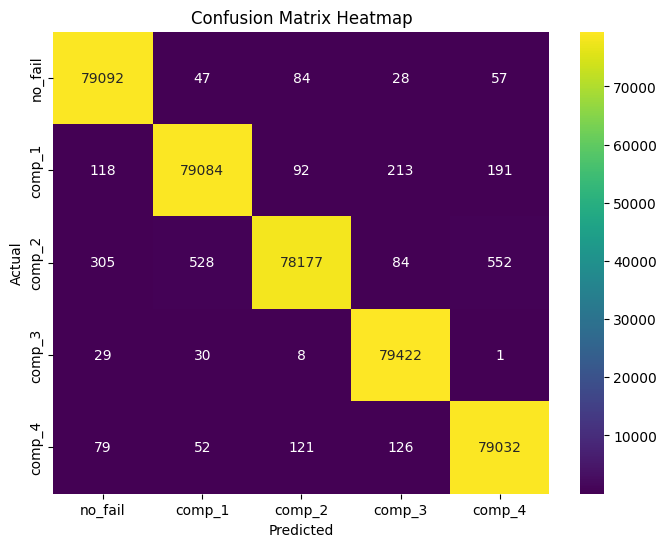

In [ ]:
# Display confusion matrix heatmap using seaborn
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d',
            xticklabels=["no_fail","comp_1","comp_2","comp_3","comp_4"],
            yticklabels=["no_fail","comp_1","comp_2","comp_3","comp_4"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [ ]:
# random forrest train, test
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy =", accuracy)

Accuracy = 0.9941995009457882


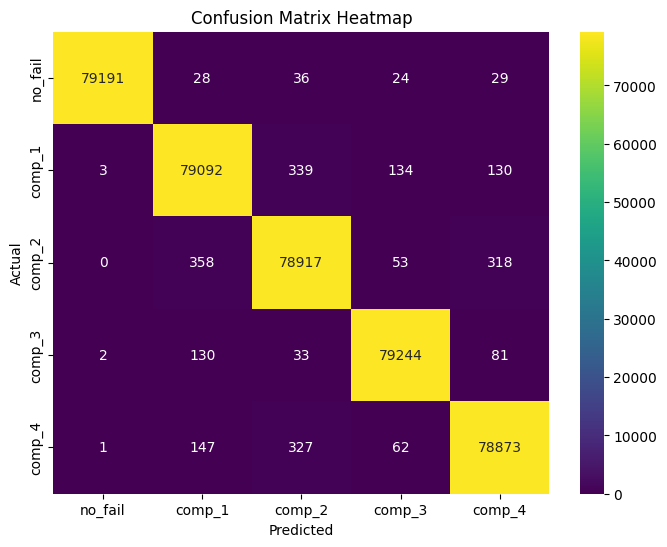

In [ ]:
# Display confusion matrix heatmap using seaborn
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d',
            xticklabels=["no_fail","comp_1","comp_2","comp_3","comp_4"],
            yticklabels=["no_fail","comp_1","comp_2","comp_3","comp_4"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.14.0'

In [ ]:
# initialize NN
ann = tf.keras.models.Sequential()

In [ ]:
# 3 hidden layers, 1 final result layer
ann.add(tf.keras.layers.Dense(units=30, activation= "relu"))
ann.add(tf.keras.layers.Dense(units=800, activation= "relu"))
ann.add(tf.keras.layers.Dense(units=800, activation= "relu"))
ann.add(tf.keras.layers.Dense(units=5, activation= "sigmoid"))
ann.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["accuracy"])

In [ ]:
ann.fit(X_train, y_train, batch_size= 32, epochs= 5)

Epoch 1/5
49694/49694 [==============================] - 702s 14ms/step - loss: 0.0393 - accuracy: 0.9620
Epoch 2/5
49694/49694 [==============================] - 704s 14ms/step - loss: 0.0177 - accuracy: 0.9827
Epoch 3/5
49694/49694 [==============================] - 741s 15ms/step - loss: 0.0162 - accuracy: 0.9847
Epoch 4/5
49694/49694 [==============================] - 722s 15ms/step - loss: 0.0158 - accuracy: 0.9855
Epoch 5/5
49694/49694 [==============================] - 714s 14ms/step - loss: 0.0156 - accuracy: 0.9858


In [ ]:
accur = ann.evaluate(X_test, y_test)
print("Accuracy :", accur)

12424/12424 [==============================] - 48s 4ms/step - loss: 0.0234 - accuracy: 0.9850
Accuracy : [0.023433538153767586, 0.9850358963012695]
